![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting numpy data 


In [1]:
import os ,sys, time, logging,shutil
from datetime import datetime
import numpy as np

t1 = time.time()
data=np.load("/mnt/data/chess/assets/recon_combined_1_2_3_fullres.npy")
shape,dtype=data.shape,data.dtype
D,H,W=data.shape
m,M=np.min(data),np.max(data)
print(f"np.load done in {time.time()-t1} seconds \ndtype={data.dtype} \nshape={data.shape} \nc_size={W*H*D*4:,} \nm={m} M={M}")

np.load done in 8.057951927185059 seconds 
dtype=float32 
shape=(2025, 816, 912) 
c_size=6,027,955,200 
m=-0.0024531930685043335 M=0.004590795375406742


# Show a slice along Z

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


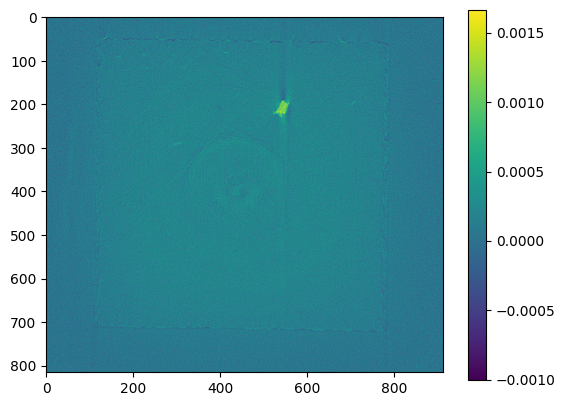

In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage

def ShowData(data,cmap="viridis"):
	print("ShowImage",data.dtype,data.shape,np.min(data),np.max(data))
	plt.imshow(data, cmap=cmap)
	plt.colorbar()
	plt.show()


Z=200
slice=data[Z,:,:]
ShowData(slice,cmap="viridis") 

# Import OpenVisus

In [3]:
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
import OpenVisus as ov
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")

# uncomment for debugging
# ov.SetupLogger(logger, output_stdout=True) 

print("OpenVisus imported")

OpenVisus imported


# Create the IDX file

In [4]:
idx_filename="./remove-me/example-numpy/visus.idx"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
assert("remove-me" in idx_filename)
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

fields=[ov.Field("data",str(data.dtype),"row_major")]
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
	compression="raw")

print(db.getDatasetBody().toString())

<dataset url="./remove-me/example-numpy/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V0120120120120120120120120120122" />
		<box value="0 912 0 816 0 2025" />
		<bitsperblock value="16" />
		<blocksperfile value="512" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<axis value="" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<timestep when="0" />
	</idxfile>
</dataset>


# Write data to OpenVisus

In [5]:
t1 = time.time()
db.write(data)
print(f"db.write done in {time.time() - t1} seconds")

db.write done in 6.533956050872803 seconds


# (OPTIONAL) Compress dataset using zip

In [6]:
# better to compress data in production
if False:
    t1 = time.time()
    db.compressDataset(["zip"])
    print(f"db.compressDataset done in {time.time()-t1} seconds")

# Show OpenVisus data

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


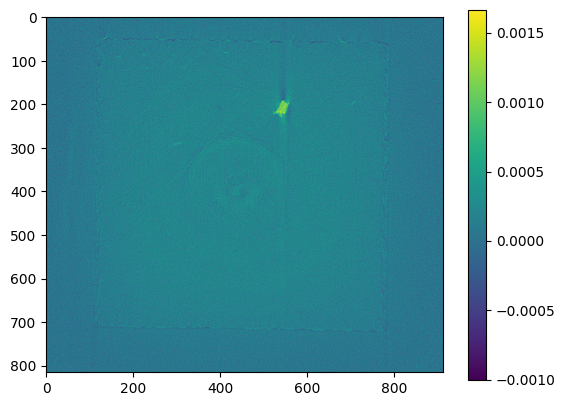

In [7]:
slice=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1)[0,:,:]
ShowData(slice)

# Show coarse to fine

ShowImage float32 (204, 456) -0.0007254779 0.0014807624


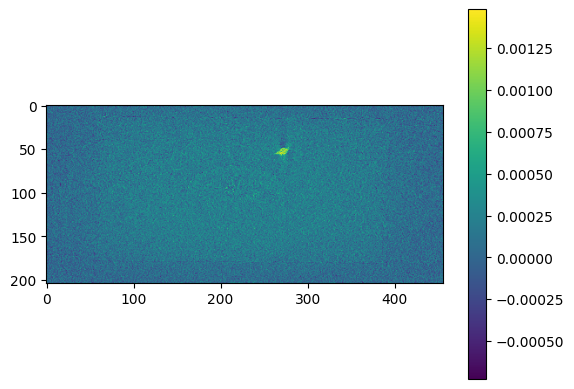

ShowImage float32 (408, 912) -0.0010000914 0.0016655645


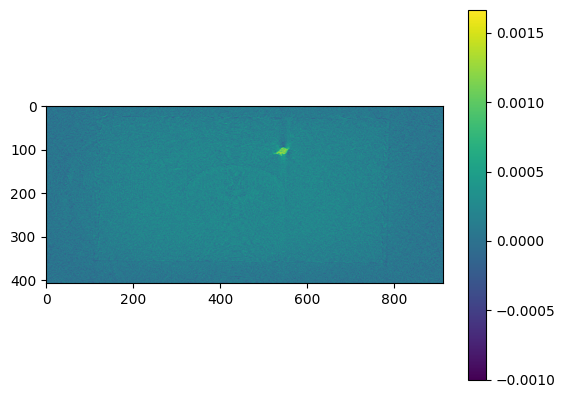

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


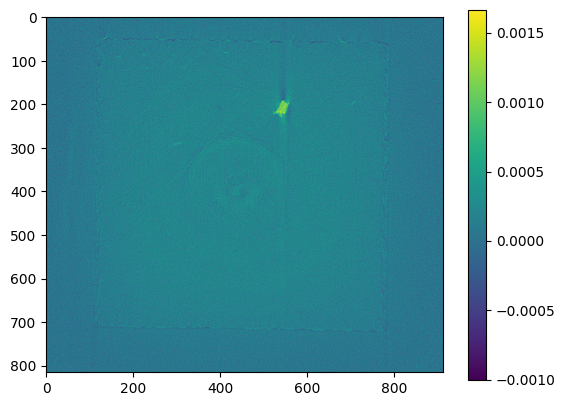

In [8]:
import os,sys
num_refinements=3
for slice in db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=num_refinements):
	ShowData(slice[0,:,:])